=======================================

**INTRODUCTION**

=======================================

This is a simple simulator to test out the effects of different dynamic data collection strategies, motivated primarily by edge computing for sensor networks. The simulator has two main components:

* **The Environment:** This controls what kinds of samples the sensor can receive. The environment can produce either a *relevant* sample or an *irrelevant* sample when queried. The distribution of samples is determined by the *type* of the environment, explained further below.
* **The Strategy:** This controls how the sensor will gather samples. As with the environment, the strategy will query samples based on its current state, either *active* or *passive*. The state transitions are also included as part of the strategy. A strategy controls both the sample rate (which affects how fast in samples are generated within the virtual time of the simulator) and the sample quality (which affects applications IRL in various ways, but which we will only track as a high or low quality sample).

Both an environment and a strategy need to be selected for the simulator to work. Certain strategies may perform better or worse than others depending on the environment.

There are two primary code blocks (with accompanying descriptive blocks):
* The simulator block, which goes over all the parameters, simulator design, and outputs
* The auxiliary block, which goes over some helpful functions you may use, including some simple data processing and plotting results

For a more broad explanation of the motivation and conceit for this simulator with pictures and an example run, please see the associated page at https://sagecontinuum.org/science/category/recent-projects.

# The Simulator

=========================================

**ENVIRONMENT TYPES**

=========================================

In our setting, the environment has two states: an *active* state in which is it tends to produce more *relevant* than *irrelevant* data, and a *passive* state, which produces the opposite. Essentially, the *active* state corresponds to an environment in which an event of interest is occurring, while the *passive* state corresponds to an environment where nothing of note is occuring. The exact probabilities of each state producing each type of data are determined by the environment's ***sampleprobs*** array. How the environment transitions between these two states is determined by its ***environtype***.

We consider the following types of environments:
* **One-State:** A static, one-state environment. It randomly produces data according to the parameters assigned to the passive state in the code.
* **Markovian:** A simple 2-state Markov chain. Transition probabilities are determined by ***transprobs***. The Markov Chain is advanced once per time unit, no matter how fast we sample.
* **Time Correlations:** A preset version of the Markovian environment. It still has the same two states and generates data stochastically, but instead of having transition probabilities, it instead comes preprogrammed with a set of time-ranges in ***times*** during which the environment is active, and otherwise it is in the passive state.
* **Preset:** A fully deterministic environment that will always produce *relevant* data in the *active* state, and *irrelevant* data in the *passive* state. The environment's states are determined by the environment's ***data*** variable, an array of labels. Each label is assumed to correspond to one time unit.



=========================================

**STRATEGY TYPES**

=========================================

As with the environment, the strategy also has two states, *active* and *passive*. Each state has a sampling frequency controlled by ***freq***, a cost (e.g., energy, cpu time, etc.) controlled by ***costs***, and a boolean variable ***highquality*** which, if true, tells the simulation to log samples collected during the active state as being high quality (if false, the simulation logs all samples as low quality). The strategy's type is determined by ***strattype***.

We consider the following types of strategies:
* **Responsive:** This strategy transitions to *active* once it senses a piece of *relevant* data. It then transitions down to *passive* after it detects a number of consecutive *irrelevant* data points equal to its ***memorycap***. A versatile
* **Waiting Time:** This strategy transitions to *active* once it senses a piece of *relevant* data. It then remains in the *active* state for a number of samples equal to its ***memorycap***, at which point it transitions back to the *passive* state if its most recent data point was *irrelevant*, otherwise, it stays *active* for another ***memorycap*** samples.

=========================================

**SIMULATOR STRUCTURE**

=========================================

The simulator has four primary outputs: the samples that were measured (***samples***), the times those samples were measured (***times***), the states of the environment over time (***states***), and the costs incurred at each time step from the measurements (***costs***). To get these four outputs over time, the simulator repeats the following steps so long as the current time ***t*** is strictly less than the stopping time ***T***:

First, **get a sample from the environment**. The environment, and possibly the current time step, are what determine what kind of sample is produced, either relevant (1) or irrelevant (0), and the strategy determines whether the sample is tagged with a high quality marker (add 10 to the sample) or not (a low quality marker is adding 0 to the sample). Hence there are 4 sample types:
* 0: Irrelevant and low quality measurement
* 1: Relevant and low quality measurement
* 10: Irrelevant and high quality measurement
* 11: Relevant and high quality measurement

Next, based on the sample, and the current strategy **update the outputs**.

After that, based on the sample, environment, and strategy, **update the environment and strategy states**.

Finally, **update** ***t*** **based on the new sampling frequency**. This becomes the new current time for the next iteration of the loop.

If there are no edits made to the file, the main body of the simulation starts at around line 200. You can also search for the phrase "SIMSTART" to jump to it.

In [31]:
## DYNAMIC DATA COLLECTION STRATEGY SIMULATION
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

#################################
# Helper functions / class definitions
# Edit the default values here to change the parameters of the simulation
#################################


## The strategy object, which controls how the environment is sampled
## VARS:
# strattype = the strategy type. The implemented strategies are:
#    "Responsive" ; "WaitingTime"
# state = the current state of the strategy. False = passive, True = active
# highquality = a toggle. True means that data collected when the state is active
#    will be flagged as high quality while data sampled in the passive state is
#    flagged as low quality. If False, all data is flagged as low quality.
# freqACT = the sampling frequency in the active state
# freqPAS = the sampling frequency in the passive state
# freq = the current sampling frequency at this time
# memorycap = how many time steps of memory is kept for the Markovian strategy,
#    and also how long we wait before checking again in the Waiting Time strategy.
#    Setting this to 0 means that no memory is kept, and so we always immediately
#    change our strategy based only on the current measurement.
# memory = internal variable to track how long the strategy has been waiting.
#    Do not change unless you know what you're doing!
# costs = the cost of generating a sample. First entry is for generating a low
#    quality sample, the second entry is for generative a high quality sample.
# currentcost = the current cost at this time

class strategy:
  def __init__(self,strattype="Responsive"):
    self.strattype=strattype
    self.state = False
    self.highquality = True
    self.freqACT = 1
    self.freqPAS = 1
    self.freq = 1
    self.memorycap = 10
    self.memory = 0
    self.costs = np.array([1, 2])
    self.currentcost = 1


## The environment object, which determines what data can be produced when queried
## VARS:
# environtype = the type of environment. The implemented environments are:
#     "OneState" ; "Markovian" ; "TimeCorrelations" ; "Preset"
# state = the current state of the environment. False = passive, True = active
# transprobs = the transition probabilities, used for the Markovian environment
#     type. The first entry is the probability of going from active to passive,
#     and the second is the probability of going from passive to active.
# sampleprobs = the probability of the environment returing a relevant or
#     irrelevant sample. First entry is the chance that an active environment
#     returns a relevant sample, second is the chance that a passive environment
#     returns an irrelevant sample
# times = a set of 2-element arrays, indicating the time periods during which the
#     environment is set to being active when using the TimeCorrelations type.
# self.data = a time


class environment:
  def __init__(self,environtype="Markovian"):
    self.environtype = environtype
    self.state = False
    self.transprobs = np.array([0.05,0.01]) #T->F, F->T
    self.sampleprobs = np.array([0.9,0.99]) #True returns true, F returns F
    self.times = np.array([[6,19],[33,40],[51,58],[73,79],[137,144],[150,165],[178,203],[233,265],[311,315],[323,328],[353,360],[402,408],[458,464],[470,476],[485,490],[547,559],[575,599]])
    self.data = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#
####### Get a sample from the environment
#For now, this will be an integer: 00 = irrelevant, 10 = irrelevant (high quality), 01 = relevant, 11 = relevant (high quality)
def get_sample(strat,environ):
  #Base Sample
  if (environ.environtype == "Markovian") | (environ.environtype == "OneState") | (environ.environtype == "TiemCorrelations"):
    if environ.state:
      sample = (rng.random() < environ.sampleprobs[0])
    else:
      #print(environ.sampleprobs[1])
      sample = (rng.random() > environ.sampleprobs[1])
  elif (environ.environtype == "Preset"):
    sample = environ.state

  #Add high quality modifier if needed
  if (strat.highquality and strat.state):
    return sample + (10*strat.state)
  else:
    return sample

############ Update the environment based on the sample freq & other behavior
def update_environ(environ,strat,t):

  #Markovian Update
  if environ.environtype == "Markovian":
    #If we reach a new full time step, try to advance the markov chain
    if np.floor(t + (1/strat.freq)) > np.floor(t):
      if environ.state:
        #transition from true to false with probability given by transprobs
        environ.state = rng.random() > environ.transprobs[0]
      else:
        #transition from false to true with probability given by transprobs
        environ.state = rng.random() < environ.transprobs[1]

  #Time Correlations Update
  elif environ.environtype == "TimeCorrelations":
    #if the current time is within one of the intervals, then set the state to active
    environ.state = np.any((environ.times[:,0] < t+(1/strat.freq)) & (environ.times[:,1] > t+(1/strat.freq)))

  #Preset Update
  elif environ.environtype == "Preset":
    #set the environment state according to the previous integer time unit
    current_time_index = np.floor(t+(1/strat.freq))
    environ.state = environ.data[current_time_index.astype(int)]
  return environ

########## Update the strategy based on the sample
def update_strat(sample,strat):
  #State Updates
  #Responsive
  if strat.strattype == "Responsive":
    #irrelevant sample
    if (sample == 0) | (sample == 10):
      if strat.state:
        strat.memory = strat.memory+1
        if strat.memory >= strat.memorycap:
          strat.memory = 0
          strat.state = False
    #relevant sample
    else:
      strat.memory = 0
      strat.state = True
  #Waitingtime
  elif strat.strattype == "WaitingTime":
    if not strat.state:
      if (sample == 1) | (sample == 11):
        #strat.memory = strat.memory+1
        strat.state = True
        #print("switching to high state at t = %i" % t)
    else:
      strat.memory = strat.memory+1
      if strat.memory >= strat.memorycap:
        strat.memory = 0
        if not (sample == 11) | (sample == 1):
          strat.state = False
          #print("switching to low state at t = %i" % t)
        #else:
          #print("staying on high state at t = %i" % t)


  #Update the sampling freq & current cost
  if strat.state:
    strat.freq = strat.freqACT
    strat.currentcost = strat.costs[0]
  else:
    strat.freq = strat.freqPAS
    strat.currentcost = strat.costs[1]


  return strat

#Get the next time step, truncating down if necessary

###################################################################################################################
###################################################################################################################
# ACTUAL SIMULATION START [SIMSTART]:
## Initialization

#Select the strategy - the strategies are described above.
strattype = "WaitingTime"
#Select the environment
environtype = "Preset"
#Total time for the simulation to run (in unit time, where 1 unit = 1 sample at an unadjusted sampling frequency)
T = 600
#empty list that will hold the samples.


#Strategy & environnment initialization based on earlier choices
strat = strategy(strattype=strattype)
environ = environment(environtype=environtype)

#initialization for time index
t = 0

#initialization for the outputs:
# times = the times at which we sample
# states = the states at those times
# samples = the samples we get
# costs = the cost at each time
times = np.array([])
states = np.array([])
samples = np.array([])
costs = np.array([])


#Loop logic:
#While t < T
#Get the new sample based on the current strat & environment
#Calculate out all the outputs
#then check on the environment's advancement (if at all)
#then check on the strategy's advancement (if at all)
#t = t+delta_t
#repeat until done.

while (t < T):
  newsample = get_sample(strat=strat,environ=environ)

  costs = np.append(costs,strat.currentcost)
  samples = np.append(samples,newsample)
  times = np.append(times,t)
  states = np.append(states,environ.state)

  strat = update_strat(sample=newsample,strat=strat)
  environ = update_environ(environ=environ,strat=strat,t=t)

  t = t + (1/strat.freq)

print("Sample Times: ")
print(times)
print()
print("Environment States: ")
print(states)
print()
print("Samples Generated: ")
print(samples)
print()
print("Cost Over Time: ")
print(costs)



Sample Times: 
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

# The Auxiliaries
Some helpful auxiliary functions you might use when using the simulator.

In [ ]:
import numpy as np

## Data Generator From Time Stamps
# Given an array of time stamp pairs (see formatting below), and a final time,
# generate an array of labels that can be used as input for the Preset
# environment type

def GenerateDataFromTime(times,Tmax)

  rows, cols = times.shape
  data = []
  counter = 0;
  for ii in np.arange(cols):
    currenttime = times[ii,:]
    data = np.append(data, np.append(np.zeros(currenttime[0]-counter),np.ones(currenttime[1]-currenttime[0])))
    counter = currenttime[1]

  if data.size < Tmax
    data = np.append(data, np.zeros(Tmax-data.size))

  return data


times = np.array([[100,200],[300,350]])
Tmax = 500
data = GenerateDataFromTime(times,Tmax)
print(data)

In [32]:
import numpy as np

## Data Cleaning
# Some bits of code that can take the raw data from the simulator, and produce a
# few different derived metrics of interest. Input your data here to run them,
# or copy paste at the end of the simulator code block

#sample data to be processed
samples = np.array([0,0,0,0,1,10,10,0,0,1,11,11,10,11,11,10,10,0,0])

#Removes the high quality / low quality marker on the samples
#i.e., leave just the data's relevancy or irrelevancy
rawsamples = np.mod(samples,10)
print("Raw Relevancy:", rawsamples)

#Removes the relevant/irrelevant marker on the samples
#i.e., leave just the strategy's hi/lo quality marker
rawquality = np.floor(samples/10)
print("Raw Quality:", rawquality)

#Counts the samples in each category, in the following order:
#[irrelevant/lowquality, relevant/lowquality, irrelevant/highquality, relevant/highquality]
samplebreakdown = np.array([np.sum(samples == 0),np.sum(samples == 1),np.sum(samples == 10),np.sum(samples == 11)])
print("Total Sample Breakdown:", samplebreakdown)

#Counts the total number of "activations" for the WaitingTime strategy, i.e.,
#the total number of times that we reset our memory and stay active for a
#memorycap-length period. Useful if each period corresponds to a run of a secondary,
#more expensive job that takes multiple time units to complete.
#Note that we take a ceil() to handle the case when an active period is not
#fully concluded when the simulation ends.
memorycap = 5
rawquality = np.floor(samples/10)
activations = np.ceil(np.sum(rawquality)/memorycap)
print("Total number of active periods:", activations)

Raw Relevancy: [0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0]
Raw Quality: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Total Sample Breakdown: [8 2 5 4]
Total number of active periods: 2.0


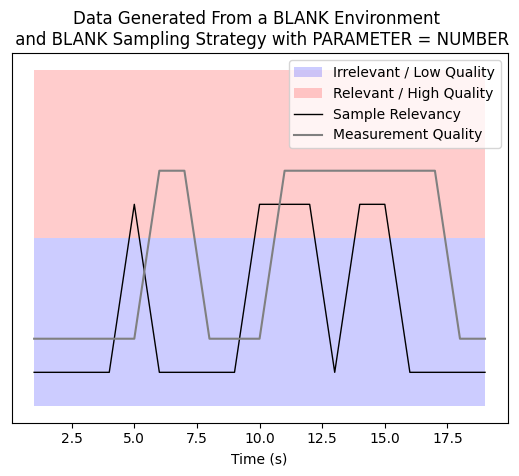

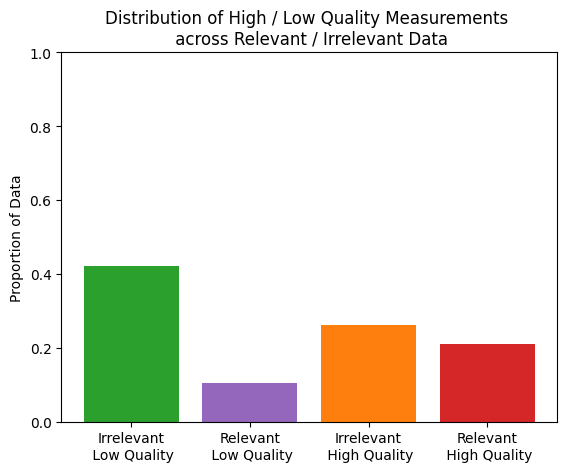

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## Plotting
# A couple different types of plots, which take either the raw data, or the cleaned
# data that can be generated by the previous block (it is regenerated here from
# an input samples)
# You can copy/paste these at the end of the simulation, or run them directly
# here by grabbing the output data from the simulation



##The sequential plot: A plot over time to visualize what exactly the environment
# and the strategy are doing. They are depicted on the same plot -- grey is the
# strategy, and black is the environment. When a line is in the red region, that
# means that the environment put out a relevant data point, or that the strategy
# measured a data point with high quality. When in the blue region, the opposite
# is true. Ideally you want these curves to be identical, or close to it.

#sample data to be processed
samples = np.array([0,0,0,0,1,10,10,0,0,1,11,11,10,11,11,10,10,0,0])
#times at which the samples were measured
times = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

#CLEAN THE DATA
rawsamples = np.mod(samples,10) #samples, independent of quality
rawquality = np.floor(samples/10) #quality, independent of samples
#total number of samples that are: [lo/irr, lo/rel, li/irr, hi/rel]
samplebreakdown = np.array([np.sum(samples == 0),np.sum(samples == 1),np.sum(samples == 10),np.sum(samples == 11)])

# actual plotting
# plot the samples over time
fig, ax = plt.subplots()
ax.fill_between(times, np.zeros(np.shape(times)), np.ones(np.shape(times)), alpha=.2, linewidth=0,color='b',label='Irrelevant / Low Quality')
ax.fill_between(times, np.ones(np.shape(times)), 2*np.ones(np.shape(times)), alpha=.2, linewidth=0,color='r',label='Relevant / High Quality')
ax.plot(times, rawsamples+0.2, '-', linewidth=1.0, color='k',label='Sample Relevancy')
ax.plot(times, rawquality+0.4, '-', color='#808080',label='Measurement Quality')
ax.legend(loc='upper right')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set(xlabel="Time (s)",title='Data Generated From a BLANK Environment \n and BLANK Sampling Strategy with PARAMETER = NUMBER')
plt.show()


##The bar plot: A plot that shows the proportions (relative frequency) of the data
# that is relevant / irrelevant, and whether it is measured with high or low
# quality.

#total number of samples that are: [lo/irr, lo/rel, hi/irr, hi/rel]
data = samplebreakdown
fig1, ax1 = plt.subplots()
labels = ['Irrelevant\n Low Quality', 'Relevant\n Low Quality', 'Irrelevant\n High Quality', 'Relevant\n High Quality']
counts = [data[0]/times.size, data[1]/times.size, data[2]/times.size, data[3]/times.size]
bar_labels = ['green', 'purple', 'orange', 'red']
bar_colors = ['tab:green', 'tab:purple', 'tab:orange', 'tab:red']
#print(counts)
ax1.bar(labels, counts, label=bar_labels, color=bar_colors,)

ax1.set_ylabel('Proportion of Data')
ax1.set(ylim=(0,1))
ax1.set(title='Distribution of High / Low Quality Measurements \n across Relevant / Irrelevant Data')
#ax.legend(title='Relevancy/Quality')
plt.show()